In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
%matplotlib inline

# Set some display settings.
sns.set(context='notebook')

In [2]:
# Inspired by https://www.textbook.ds100.org/ch/04/eda_data_types.html
from ipywidgets import interact
def peek_at_dataframe(df, n_row=10, n_col=10):
    def show_slice(start_row=0, start_col=0):
        return df.iloc[start_row : start_row + n_row, start_col : start_col + n_col]
    
    total_rows, total_cols = df.shape
    
    # See https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html#Widget-abbreviations
    interact(
        show_slice,
        start_row=(0, total_rows, n_row // 2),
        start_col=(0, total_cols, n_col // 2)
    )

In [3]:
hourly_counts_orig = pd.read_csv('data/hour.csv')
hourly_counts_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
hourly_counts = hourly_counts_orig.rename(columns={
    'dteday': 'date',
    'hr': "hour",
    'mnth': "month",
    'weekday': "day_of_week",
    'holiday': "is_holiday",
    'workingday': "is_workingday",
    'weathersit': "weather_type",
    "hum": "humidity",
    'cnt': "riders"
}).drop(["instant", "casual", "registered"], axis=1)
hourly_counts['day_of_year'] = pd.to_datetime(hourly_counts['date']).dt.dayofyear
cols = list(hourly_counts.columns)
cols.insert(1, cols.pop(cols.index("day_of_year")))
cols.insert(4, cols.pop(cols.index("day_of_week")))
cols.insert(4, cols.pop(cols.index("day_of_week")))
hourly_counts = hourly_counts[cols]

In [5]:
assert hourly_counts['hour'].max() == 23
assert hourly_counts['riders'].max() > 900

In [6]:
peek_at_dataframe(hourly_counts)

interactive(children=(IntSlider(value=0, description='start_row', max=17379, step=5), IntSlider(value=0, descr…

In [7]:
hourly_counts.head()

,date,day_of_year,season,yr,day_of_week,month,hour,is_holiday,is_workingday,weather_type,temp,atemp,humidity,windspeed,riders
0,2011-01-01,1,1,0,6,1,0,0,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,1,0,6,1,1,0,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,1,0,6,1,2,0,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,1,0,6,1,3,0,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,1,0,6,1,4,0,0,1,0.24,0.2879,0.75,0.0,1


In [8]:
hourly_counts['timestamp'] = pd.to_datetime(hourly_counts['date']) + pd.to_timedelta(hourly_counts['hour'], unit='h')

In [9]:
hourly_counts_ts = hourly_counts.set_index('timestamp')

In [10]:
daily_counts = hourly_counts.groupby('date').agg({
    "day_of_year": "first",
    "season": "first",
    "day_of_week": "first",
    "month": "first",
    "is_holiday": "first",
    "is_workingday": "first",
    "weather_type": "mean",
    "temp": "mean",
    "atemp": "mean",
    "humidity": "mean",
    "windspeed": "mean",
    "riders": "sum"
}).reset_index()
daily_counts['date'] = pd.to_datetime(daily_counts['date'])
daily_counts = daily_counts.set_index('date')
daily_counts.head()

,day_of_year,season,day_of_week,month,is_holiday,is_workingday,weather_type,temp,atemp,humidity,windspeed,riders
date,,,,,,,,,,,,
2011-01-01,1,1,6,1,0,0,1.583333,0.344167,0.363625,0.805833,0.160446,985
2011-01-02,2,1,0,1,0,0,1.956522,0.363478,0.353739,0.696087,0.248539,801
2011-01-03,3,1,1,1,0,1,1.000000,0.196364,0.189405,0.437273,0.248309,1349
2011-01-04,4,1,2,1,0,1,1.043478,0.200000,0.212122,0.590435,0.160296,1562
2011-01-05,5,1,3,1,0,1,1.000000,0.226957,0.229270,0.436957,0.186900,1600


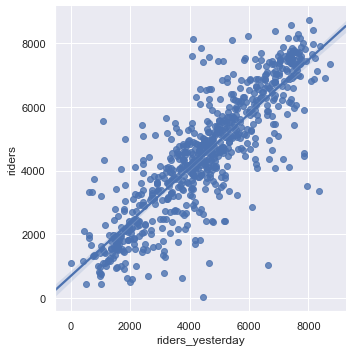

In [14]:
sns.lmplot(x='riders_yesterday', y='riders', data=daily_counts.assign(riders_yesterday=daily_counts.riders.shift()))

In [96]:
if False:
    X = hourly_counts_ts[["day_of_year", 'season', 'day_of_week', 'month', 'hour', 'is_holiday', 'is_workingday', 'weather_type', 'temp', 'atemp', 'humidity', 'windspeed']]
    y = hourly_counts_ts['riders']
else:
    X = daily_counts[[
        #"day_of_year",
        #'season',
        #'day_of_week',
        #'month',
        #'is_holiday',
        #'is_workingday',
        #'weather_type',
        #'temp',
        'atemp',
        #'humidity',
        #'windspeed'
    ]]
    y = daily_counts['riders']

In [97]:
for train_indices, test_indices in TimeSeriesSplit(n_splits=5).split(X):
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
    # baseline linear regression, no feature engineering
    clf = LinearRegression().fit(X_train, y_train)
    
    print(len(train_indices), clf.score(X_test, y_test))

126 -1.0496808161430935
247 -0.023534428924798734
368 -0.6525745349702432
489 -3.899603245278188
610 -0.3883460830265948


In [98]:
for train_indices, test_indices in TimeSeriesSplit(n_splits=5).split(X):
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
    # give the model access to the immediately previous datapoints
    X_train = X_train.assign(
        y_prev_day=y_train.shift(fill_value=0.), y_prev_week=y_train.shift(7, fill_value=0.)
    )
    X_test = X_test.assign(
        y_prev_day=y_test.shift(fill_value=0.), y_prev_week=y_test.shift(7, fill_value=0.)
    )
    clf = LinearRegression().fit(X_train, y_train)
    
    print(clf.score(X_test, y_test))

-0.7842309407173792
0.35631715601670355
0.33067049403869686
-0.6010986934600235
0.5157059058903501


(Note that these "score" values are R^2's.)

In [99]:
clf.coef_

array([1.66522616e+03, 5.41437442e-01, 2.47366688e-01])

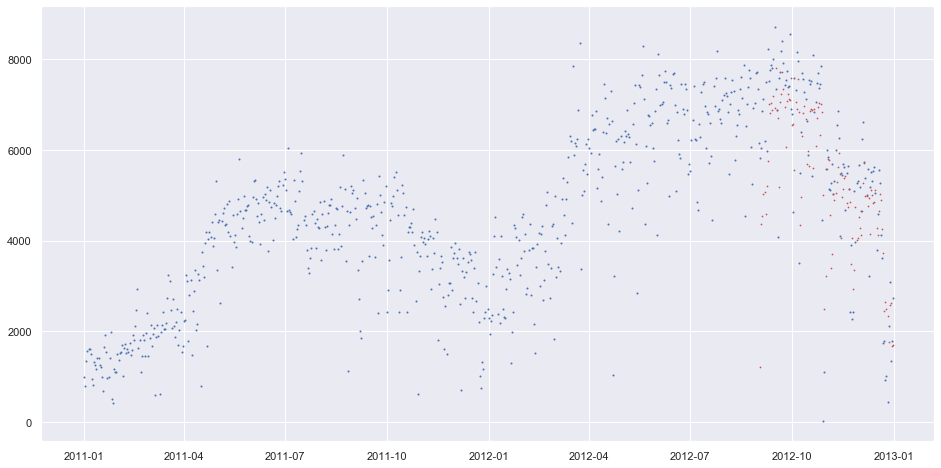

In [100]:
y_test_pred = pd.Series(clf.predict(X_test), index=y_test.index)

plt.figure(figsize=(16,8))
plt.scatter(y_train.index, y_train, s=1., color='b')
plt.scatter(y_test.index, y_test, s=1., color='b')
plt.scatter(y_test_pred.index, y_test_pred, s=.5, color='r')

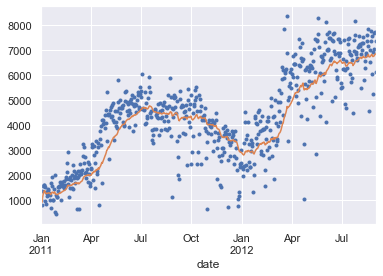

In [117]:
y_train.plot(style='.')
y_train.ewm(span=50).mean().plot()

,date,riders
0,2011-01-01,985.000000
1,2011-01-02,883.800000
2,2011-01-03,1070.807309
3,2011-01-04,1232.633416
4,2011-01-05,1338.094371
5,2011-01-06,1407.678717
6,2011-01-07,1432.334036
7,2011-01-08,1324.648261
8,2011-01-09,1215.289589
9,2011-01-10,1237.494713


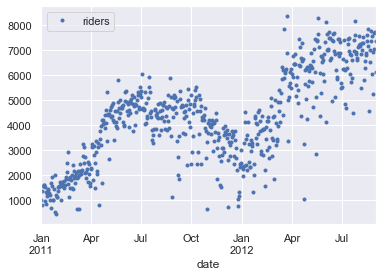

In [110]:
y_train.to_frame().reset_index().plot(x='date', y='riders', style=".")
y_train.ewm(span=10).mean().to_frame().reset_index()#plot(x='date', y='riders', style=".")

In [50]:
y_train_day = y_train.resample("d").sum()
y_test_day = y_test.resample("d").sum()
y_test_pred = pd.Series(clf.predict(X_test), index=y_test.index)
y_test_pred_day = y_test_pred.resample("d").sum()

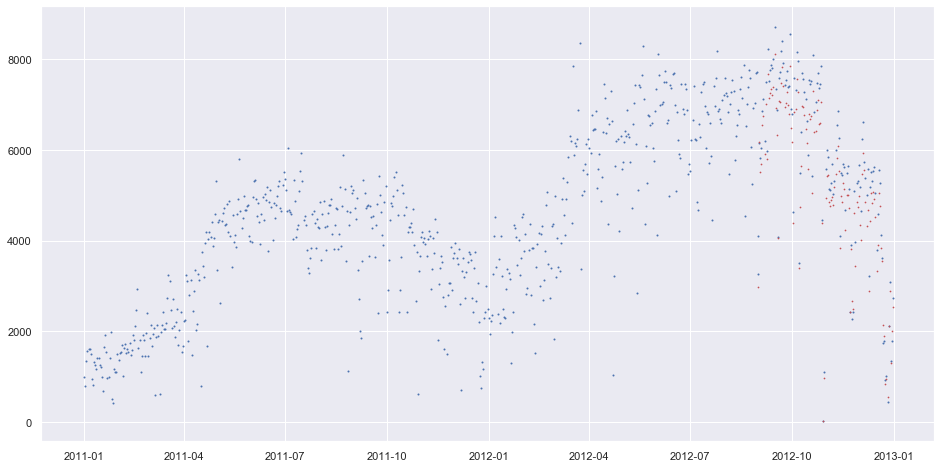

In [56]:
plt.figure(figsize=(16,8))
plt.scatter(y_train_day.index, y_train_day, s=1., color='b')
plt.scatter(y_test_day.index, y_test_day, s=1., color='b')
plt.scatter(y_test_pred_day.index, y_test_pred_day, s=.5, color='r')